<a href="https://colab.research.google.com/github/HeleneFabia/covid-19-tweet-sentiment-analysis/blob/master/covid_19_tweet_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Tweet Sentiment Analysis: LSTM

The goal of this project is to classify tweets about COVID-19 into positive sentiment and negative emotion. This project also serves to make myself more familiar with state-of-the-art NLP models.

## Importing and preprocessing the data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.max_colwidth', 500)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

import re
import os
import time
import gc
from tqdm.notebook import tqdm_notebook as tqdm

from keras.preprocessing import text, sequence

import sklearn.metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

import shutil
import logging

import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [7]:
train = pd.read_csv('/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/Corona_NLP_test.csv', encoding='latin1')

In [8]:
train.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


As we can see, the data includes the Twitter username, their location, the date the tweet was posted, the text of the tweet and the corresponding label (extremely negative, negative, neutral, positive, extremely positive).

Since I do not want the project to be too complex, I decide to only work with the text data and omit the rest of the columns. To further simply the task at hand, I decide to turn the problem from a multiclass classification problem into a binary classification problem. As such, I drop the tweets labeled as neutral and merge the classes 'Positive' and 'Extremely Positive', and 'Negative' and 'Extremely Negative'.

For the model to be able to process the labels, I turn them into numerical labels (0 for negative, 1 for positive).

In [9]:
train = train[['OriginalTweet', 'Sentiment']]
test = test[['OriginalTweet', 'Sentiment']]

train = train[train.Sentiment != 'Neutral']
test = test[test.Sentiment != 'Neutral']

label2idx = {'Extremely Negative': 0, 
            'Negative': 0,
            'Positive': 1,
            'Extremely Positive': 1}

train['Sentiment'] = train['Sentiment'].replace(label2idx)
test['Sentiment'] = test['Sentiment'].replace(label2idx)

I then build a function that removes any punctuation, emojis and urls.

In [10]:
def preprocess(data):
    
    """Removes punctuation, emojis and urls form a text."""
    
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text
    
    def remove_url(text):
        return re.sub(r'https?:\/\/\S+|www\.\S+', '', text)

    def remove_emoji(text):
        emoji_pattern = re.compile(
            '['
            u'\U0001F600-\U0001F64F' 
            u'\U0001F300-\U0001F5FF'  
            u'\U0001F680-\U0001F6FF' 
            u'\U0001F1E0-\U0001F1FF'
            u'\U00002702-\U000027B0'
            u'\U000024C2-\U0001F251'
            ']+',
            flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    data = data.astype(str).apply(lambda x: remove_url(x))
    data = data.astype(str).apply(lambda x: remove_emoji(x))
    
    return data

In [11]:
x_train = preprocess(train['OriginalTweet'])
y_train = train['Sentiment']
x_test = preprocess(test['OriginalTweet'])
y_test = test['Sentiment']

In [12]:
x_train.sample(3)

30196                      US death toll is way less than estimated  This I hope will bring back consumer confidence  coronavirus  Covid 19  CoronavirusUSA
13325                                  We will get through this by people helping people and not stock piling food and toiletries  selfish pricks  Covid 19
14622     rice prices soar to two year high  traders blame it on  coronavirus panic buying  writes  YasirWardad https   t co hIXzS1DKdo  FE via  febdonline
Name: OriginalTweet, dtype: object

## Word embeddings with GloVe

I decided to use pretrained GloVe embeddings and tokenize the tweets with the Keras Tokenizer.

The Keras tokenizer creates a vocabulary with all the tokens in a text and assigns an index to each tolen according to its frequency in the text. Next, it transforms the text into a sequence of word indices which can then be used as an input for a model.

In [13]:
tokenizer = text.Tokenizer() # instantiate tokenizer class
tokenizer.fit_on_texts(list(x_train) + list(x_test)) # create vocab

x_train = tokenizer.texts_to_sequences(x_train) # transforms training tweets into sequences of word indices
x_test = tokenizer.texts_to_sequences(x_test) # transforms test tweets into sequences of word indices

SEQ_LEN = 110
x_train = sequence.pad_sequences(x_train, maxlen=SEQ_LEN, padding='post') # add padding up to SEQ_LEN
x_test = sequence.pad_sequences(x_test, maxlen=SEQ_LEN, padding='post')

Here's the first tweet in the training set represented as indices (according to the respective token in the vocab).

In [14]:
x_train[0]

array([  570,   977,     2,    39,  2383,   268,     2,  2741,   881,
        1316,  1036,   435,   445,    26,   881,  1316,     6,  2383,
         897,  3827,  3540,  4994,   554,    47,    58,    57,  2557,
          51, 22852,  3131,   176,     6,  1055,  2337,    53,    40,
         110,   259,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

I then build an embedding matrix with the pretrained word vectors. Please have a look at the scrip `glove_embedding.py` to see the code for loading the GloVe embeddings. 

In this notebook here, I simply load the embedding matrix I saved previously.

In [20]:
glove_matrix, unknown_words = torch.load('/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/glove_embedding.pt')

Lastly, I convert the training and test set into torch tensors, put them into a Dataset and split the training set to obtain a validation set.

In [21]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).to(device)
y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)

x_test_torch = torch.tensor(x_test, dtype=torch.long).to(device)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long).to(device)

In [22]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape, y_test_torch.shape

(torch.Size([33444, 110]),
 torch.Size([3179, 110]),
 torch.Size([33444]),
 torch.Size([3179]))

In [23]:
train_dataset = TensorDataset(x_train_torch, y_train_torch)
test_set = TensorDataset(x_test_torch, y_test_torch)

train_set, val_set = torch.utils.data.random_split(train_dataset, [26755, 6689])

## Model

It's time to build a neural net. Here, I build a classifier model with two bidirectional LSTM layers and two fully connected layers.

In [24]:
class Dropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)
        x = x.permute(0, 3, 2, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 2, 1)
        x = x.squeeze(2)
        return x
    
class LSTM_Classifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, dropout_p):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True #SET TO TRUE/FALSE!
        self.embedding_dropout = Dropout(dropout_p)
        
        self.rnn1 = nn.LSTM(input_size=self.embedding_dim,
                           hidden_size=self.hidden_dim,
                           bidirectional=True)
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim * 2,
                           hidden_size=self.hidden_dim,
                            bidirectional=True)
        self.fc1 = nn.Linear(self.hidden_dim * 4, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, inputs):
        
        embedded = self.embedding(inputs)
        embedded_dropout = self.embedding_dropout(embedded)
        
        output, _ = self.rnn1(embedded_dropout)
        output, _ = self.rnn2(output)
        
        avg_output = torch.mean(output, 1) 
        max_output, _ = torch.max(output, 1) 
        output_conc = torch.cat((avg_output, max_output), 1) 
        
        output = F.relu(self.fc1(output_conc))
        output = self.fc2(output)

        return output

As the loss function, I use Binary Cross Entropy Loss.

In [36]:
loss_fn = nn.BCEWithLogitsLoss()

## Training the model

In [26]:
def train_model(model, train, val, lr, batch_size, n_epochs, checkpoint_path, best_model_path, update_embedding_weights=False, save_model=False):
    
    # define model parameters depending on whether embedding weights should be updated or not
    if update_embedding_weights:
        params = model.parameters()
    else:
        params = list(model.rnn1.parameters()) + list(model.rnn2.parameters()) + list(model.fc1.parameters()) + list(model.fc2.parameters())
    
    # define optimizer
    optimizer = torch.optim.Adam(params, lr=lr)
    
    # get training and validation data loader
    train_dl = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

    # define lists and variable to store loss and accuracy values
    all_val_preds = []
    losses_train = []
    losses_val = []
    epoch_loss_train = []
    epoch_loss_val = []
    epoch_acc_train = []
    epoch_acc_val = []
    best_val_acc = 0
    
    for epoch in range(n_epochs):
        
        start_time = time.time()
        model.train()
        
        # define variables to store loss and accuracy values per epoch
        avg_loss_train = 0
        avg_loss_val = 0
        avg_acc_train = 0
        avg_acc_val = 0
        
        # loop over training set
        for data in train_dl:
            
            x_batch = data[0].cuda()
            y_batch = data[1].float().cuda()

            # forward propogation
            y_pred = model(x_batch).squeeze(1) 

            #backward propagation
            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            # get loss of batch
            avg_loss_train += loss.item()
            losses_train.append(loss.item())
            
            # get accuracy of batch 
            y_pred_bin = []
            for pred in y_pred:
                if pred >= 0.5:
                    y_pred_bin.append(1)
                else:
                    y_pred_bin.append(0)
            tens_y_pred_bin = torch.FloatTensor(y_pred_bin).cpu()
            y_batch = y_batch.cpu()
            train_batch_acc = accuracy_score(y_batch, tens_y_pred_bin)
            avg_acc_train += train_batch_acc
        
        # get average training loss of epoch 
        avg_loss_train = avg_loss_train/len(train_dl)
        epoch_loss_train.append(avg_loss_train)
        
        # get average training accuracy of epoch
        avg_acc_train = avg_acc_train/len(train_dl)
        epoch_acc_train.append(avg_acc_train)
        
        model.eval()
        with torch.no_grad():

            # loop over validation set
            for data in val_dl:

                x_batch = data[0].cuda()
                y_batch = data[1].float().cuda()

                y_pred = model(x_batch).squeeze(1)
                loss = loss_fn(y_pred, y_batch)

                # get loss of batch
                avg_loss_val += loss.item()
                losses_val.append(loss.item())

                # get predictions of batch
                y_pred = torch.sigmoid(y_pred)
                all_val_preds.append(y_pred)
                
                # get accuracy of batch
                y_pred_bin = []
                for pred in y_pred:
                    if pred >= 0.5:
                        y_pred_bin.append(1)
                    else:
                        y_pred_bin.append(0)
                tens_y_pred_bin = torch.FloatTensor(y_pred_bin).cpu()
                y_batch = y_batch.cpu()
                val_batch_acc = accuracy_score(y_batch, tens_y_pred_bin)
                avg_acc_val += val_batch_acc

            # get average validation loss of epoch
            avg_loss_val = avg_loss_val/len(val_dl)
            epoch_loss_val.append(avg_loss_val)
            
            # get average validation accuracy of epoch
            avg_acc_val = avg_acc_val/len(val_dl)
            epoch_acc_val.append(avg_acc_val)
        
        stats = {
            'Epoch Loss Training': epoch_loss_train,
            'Epoch Loss Validation': epoch_loss_val,
            'Epoch Accuracy Training': epoch_acc_train,
            'Epoch Accuracy Validation': epoch_acc_val,
            'Validation Predictions': all_val_preds}

        elapsed_time = time.time() - start_time

        print(f'### Epoch {epoch+1}/{n_epochs}###')
        print(f'Training: loss = {avg_loss_train:.4f}, accuracy = {avg_acc_train:.4f}')
        print(f'Validation: loss = {avg_loss_val:.4f}, accuracy = {avg_acc_val:.4f}')
        print(f'time = {elapsed_time:.2f} s')

        # save model
        if save_model:
            
            checkpoint = {
              'epoch': epoch + 1,
              'validation_accuracy': avg_acc_val,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict()}

            save_checkpoint(checkpoint, False, checkpoint_path, best_model_path, avg_acc_val)

            if avg_acc_val >= best_val_acc:
                print(f'Validation accuracy has improved ({best_val_acc:.4f} --> {avg_acc_val:.4f}). Saving model...')
                save_checkpoint(checkpoint, True, checkpoint_path, best_model_path, avg_acc_val)
                best_val_acc = avg_acc_val

            logging.basicConfig(filename='/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/training_prints.log', filemode='w', level='INFO')
            logging.info(f'### Epoch {epoch+1}/{n_epochs}###')
            logging.info(f'Training: loss = {avg_loss_train:.4f}, accuracy = {avg_acc_train:.4f}')
            logging.info(f'Validation: loss = {avg_loss_val:.4f}, accuracy = {avg_acc_val:.4f}')
            logging.info(f'time = {elapsed_time:.2f} s')
            logging.info('Validation Accuracy of Best Model: {best_val_acc}')
        
        else:
            if avg_acc_val >= best_val_acc:
              best_val_acc = avg_acc_val

    print(f'###Validation Accuracy of Best Model: {best_val_acc:.4f}###')
        
    return stats

In [28]:
def save_checkpoint(state, is_best, checkpoint_path, best_model_path, avg_acc_val):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint (True/False)
    checkpoint_path: path to save checkpoint (e.g. './experiment/current_checkpoint.pt')
    best_model_path: path to save best model (e.g. './experiment/best_model.pt')
    """

    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_fpath)

In [29]:
def plot_learning_curve(train_values, val_values, num_epochs, title):
    fig, axes = plt.subplots(figsize=(12, 8))
    plt.plot(train_values)
    plt.plot(val_values)
    plt.legend(['train', 'val'])
    plt.title(title)
    labels = list(range(1,num_epochs+1))
    plt.xticks(range(0,num_epochs), labels)
    axes.set_ylim([0,1])
    plt.show()

In [30]:
def plot_roc_curve(fpr, tpr, auc):
    plt.title(f'Receiver Operating Characteristic (ROC) Curve: \n Auc Score = {auc:.4f}')
    plt.plot(fpr, tpr, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def ROC_curve(val_set, val_preds, n_epochs):
    y_true = val_set[:][1].cpu()
    val_preds_comp = [i.item() for l in val_preds for i in l]
    last_batch = len(val_preds_comp)/n_epochs*(n_epochs-1)
    #print(last_batch)
    fpr, tpr, thresholds = roc_curve(y_true, val_preds_comp[int(last_batch):])
    auc = roc_auc_score(y_true, val_preds_comp[int(last_batch):])
    plot_roc_curve(fpr, tpr, auc)

I first instantiate the model and train it given the following hyperparameters:
- hidden_dim=128
- dropout_p=0.3
- lr=0.001,
- batch_size=512
- n_epochs=20

In [33]:
model = LSTM_Classifier(vocab_size=len(tokenizer.word_index), hidden_dim=128, embedding_dim=300, output_dim=1, embedding_matrix=glove_matrix, dropout_p=0.3).cuda()

In [37]:
stats = train_model(model, train_set, val_set, lr=0.001, batch_size=512, n_epochs=20, checkpoint_path='/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/experiment_7/current_checkpoint.pt', best_model_path=f'/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/experiment_7/best_model.pt', update_embedding_weights=False, save_model=True)

### Epoch 1/20###
Training: loss = 0.6857, accuracy = 0.4698
Validation: loss = 0.6518, accuracy = 0.6977
time = 8.43 s
### Epoch 2/20###
Training: loss = 0.5054, accuracy = 0.7380
Validation: loss = 0.4053, accuracy = 0.8152
time = 8.33 s
### Epoch 3/20###
Training: loss = 0.4111, accuracy = 0.8022
Validation: loss = 0.3756, accuracy = 0.8282
time = 8.47 s
### Epoch 4/20###
Training: loss = 0.3879, accuracy = 0.8146
Validation: loss = 0.3479, accuracy = 0.8508
time = 8.55 s
### Epoch 5/20###
Training: loss = 0.3653, accuracy = 0.8288
Validation: loss = 0.3358, accuracy = 0.8517
time = 8.66 s
### Epoch 6/20###
Training: loss = 0.3466, accuracy = 0.8407
Validation: loss = 0.3153, accuracy = 0.8657
time = 8.73 s
### Epoch 7/20###
Training: loss = 0.3300, accuracy = 0.8497
Validation: loss = 0.3150, accuracy = 0.8657
time = 8.76 s
### Epoch 8/20###
Training: loss = 0.3148, accuracy = 0.8600
Validation: loss = 0.2866, accuracy = 0.8798
time = 8.80 s
### Epoch 9/20###
Training: loss = 0.294

In [39]:
loss_train, loss_val, acc_train, acc_val = stats['Epoch Loss Training'], stats['Epoch Loss Validation'], stats['Epoch Accuracy Training'], stats['Epoch Accuracy Validation']

Let's have a look at the learning curves:

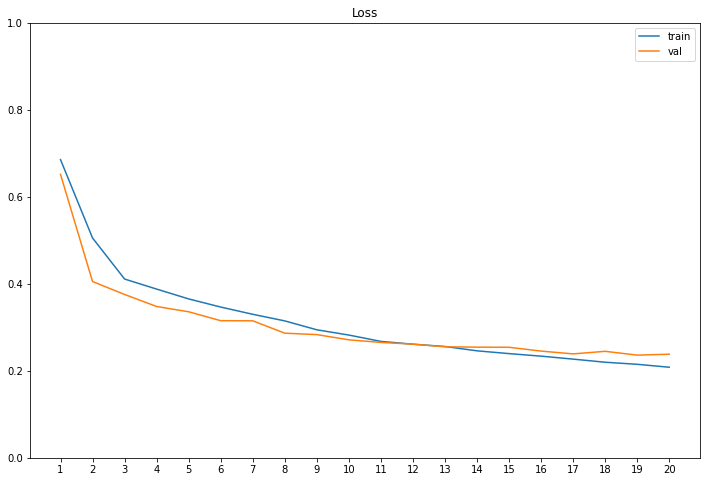

In [40]:
plot_learning_curve(loss_train, loss_val, 20, 'Loss');

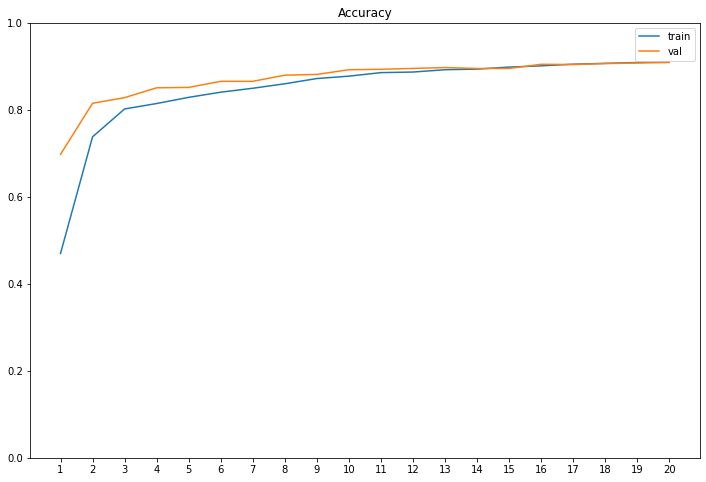

In [41]:
plot_learning_curve(acc_train, acc_val, 20, 'Accuracy');

Since this is the best performance I could achieve after several experiments (plus, where the training was fast, i.e. around three minutes), I now test my model on the test set.

## Testing

In [44]:
model_testing = LSTM_Classifier(vocab_size=len(tokenizer.word_index), hidden_dim=128, embedding_dim=300, output_dim=1, embedding_matrix=glove_matrix, dropout_p=0.3).cuda()

In [45]:
best_model = torch.load('/content/drive/My Drive/Kaggle/COVID-19_Sentiment_Analysis/experiment_7/best_model.pt')

In [46]:
model_testing.load_state_dict(best_model['state_dict'])
model_testing.eval()

LSTM_Classifier(
  (embedding): Embedding(75036, 300)
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (rnn1): LSTM(300, 128, bidirectional=True)
  (rnn2): LSTM(256, 128, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [47]:
def test(model, test, batch_size):
    
    # build the test data loader
    test_dl = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    
    # define variables and lists to store predictions and loss/accuracy
    test_preds = []
    loss_test = 0
    acc_test = 0

    with torch.no_grad():
        
        # loop through test dataloader
        for data in test_dl:
            x_batch = data[0].cuda()
            y_batch = data[1].float().cuda()

            y_pred = model(x_batch).squeeze(1)
            loss = loss_fn(y_pred, y_batch)
            loss_test += loss.item()

            y_pred = torch.sigmoid(y_pred)
            test_preds.append(y_pred)

            y_pred_bin = []
            for pred in y_pred:
                if pred >= 0.5:
                    y_pred_bin.append(1)
                else:
                    y_pred_bin.append(0)
            tens_y_pred_bin = torch.FloatTensor(y_pred_bin).cpu()
            y_batch = y_batch.cpu()
            batch_acc = accuracy_score(y_batch, tens_y_pred_bin)
            acc_test += batch_acc

    # get loss
    loss_test = loss_test/len(test_dl)
    #get accuracy
    acc_test = acc_test/len(test_dl)

    print(f'Test Loss: {loss_test:.4f}')
    print(f'Test Accuracy: {acc_test:.4f}')

    return test_preds

In [48]:
preds = test(model_testing, test_set, batch_size=512)

Test Loss: 0.2879
Test Accuracy: 0.8866


As can be seen above, the overall test accuracy for my model is 0.8866

Things I haven't tried but might further improve the model:
- including a learning rate scheduler
- adding more LSTM layers to the model
- find a way to update the embedding weights during training without horribly overfitting the training set (which happened when I tried to do this)